In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from keras.layers import Input,Dense, Dropout
from keras.models import Model,Sequential
from sklearn.metrics import roc_curve, auc
sys.path.append('/Users/chenpete/Documents/ESP/practicum/autoencoders/code')
from utils import *
from sklearn.neighbors import BallTree

Using TensorFlow backend.


### Link to Paper

https://arxiv.org/pdf/1809.10717.pdf

In [2]:
DATA_DIR = '/Users/PeterC/Documents/gt/practicum/autoencoders/data/'
DATA_DIR = '/Users/chenpete/Documents/ESP/practicum/autoencoders/data/'

df = pd.read_csv(DATA_DIR + 'paper_mill_rare_events.csv')
df['time'] = pd.to_datetime(df['time'])


In [3]:
df.columns

Index(['time', 'y', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9',
       'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19',
       'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29',
       'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39',
       'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49',
       'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59',
       'x60', 'x61'],
      dtype='object')

# XGBoost Feature Importance 

In [6]:
import xgboost 

y_cols = ['y']
X = df[['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9',
       'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19',
       'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29',
       'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39',
       'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49',
       'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59',
       'x60', 'x61']]
y = df[y_cols]
xgb = xgboost.XGBClassifier()
xgb.fit(X,y)

/Users/chenpete/Documents/code/DL/dlenv/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/chenpete/Documents/code/DL/dlenv/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

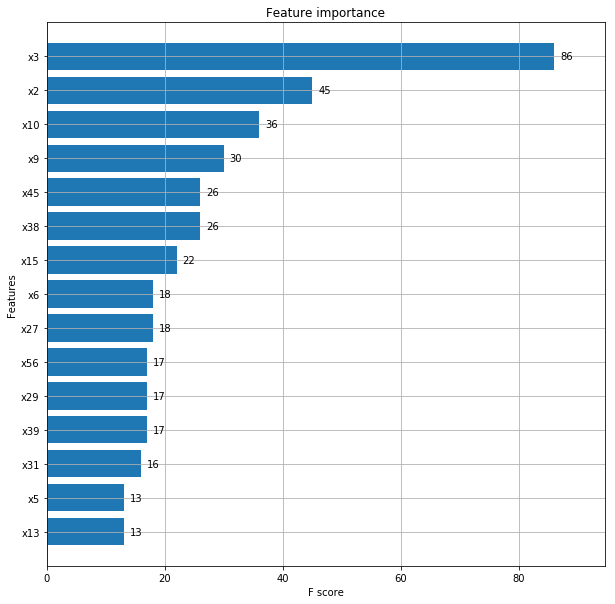

In [7]:
fig, ax = plt.subplots(figsize=(10,10))
xgboost.plot_importance(xgb, max_num_features=15, height=0.8, ax=ax)
plt.show()

In [10]:
non_scale_cols = ['time','y_early','y_rank','y']
param_cols = ['x3','x2','x10','x9','x45','x38','x15','x6','x27','x56','x29','x39','x31','x5','x13']
y_col = 'y_early'
early_step = 4
X_train, X_test, y_train, y_test,y_rank_train, y_rank_test  = preprocess_data(df,param_cols,y_col, non_scale_cols,early_step)

In [11]:
X_train.shape

(16007, 15)

# Model 1: Layer autoencoder - standard scaler (regression

In [12]:
str(param_cols)

"['x3', 'x2', 'x10', 'x9', 'x45', 'x38', 'x15', 'x6', 'x27', 'x56', 'x29', 'x39', 'x31', 'x5', 'x13']"

In [13]:
def simple_ann_autoencoder_regression(param_cols,layer1,layer2,layer3):
    model = Sequential()
    model.add(Dense(units = layer1,activation='relu',input_shape = (len(param_cols),)))
    model.add(Dense(units = layer2,activation='relu'))
    model.add(Dense(units = layer3,activation='relu'))
    model.add(Dense(units = len(param_cols),activation='linear'))
    model.compile(optimizer='adam', loss='mse')
    return model

In [14]:
model = simple_ann_autoencoder_regression(param_cols,12,6,12)
model.name = str(param_cols)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                192       
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 78        
_________________________________________________________________
dense_3 (Dense)              (None, 12)                84        
_________________________________________________________________
dense_4 (Dense)              (None, 15)                195       
Total params: 549
Trainable params: 549
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Use tf.cast instead.
Epoch 1/75
16007/16007 [==============================] - 1s 36us/step - loss: 0.6939
Epoch 2/75
16007/16007 [==============================] - 0s 23us/step - loss: 0.4386
Epoch 3/75
16007/16007 [==============================] - 0s 23us/step - loss: 0.3651
Epoch 4/75
16007/16007 [==============================] - 0s 23us/step - loss: 0.3144
Epoch 5/75
16007/16007 [==============================] - 0s 23us/step - loss: 0.2756
Epoch 6/75
16007/16007 [==============================] - 0s 23us/step - loss: 0.2588
Epoch 7/75
16007/16007 [==============================] - 0s 23us/step - loss: 0.2489
Epoch 8/75
16007/16007 [==============================] - 0s 23us/step - loss: 0.2406
Epoch 9/75
16007/16007 [==============================] - 0s 23us/step - loss: 0.2333
Epoch 10/75
16007/16007 [==============================] - 0s 23us/step - loss: 0.2281
Epoch 11/75
16007/16007 [==============================] - 0s 23us/step - loss: 0.2245
Epoc

Text(0.5, 1.0, 'loss history')

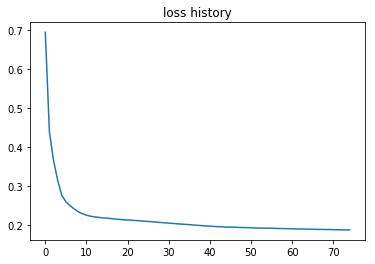

In [15]:
history_callback = model.fit(X_train,X_train,epochs=75,batch_size = 32)
loss_history = history_callback.history['loss']

plt.plot(loss_history)
plt.title('loss history')

In [16]:
model.save('autoencoder_12_6_12.h5')

In [18]:
X_pred_test = model.predict(X_test)

X_pred_train = model.predict(X_train)

X_pred_test.shape

df_results_test = results_df(X_test,X_pred_test,y_test,y_rank_test)
df_results_train = results_df(X_train,X_pred_train,y_train,y_rank_train)

df_results_test['y_rank'].value_counts()

0    1779
5     124
4     124
3     123
2     122
1     119
Name: y_rank, dtype: int64

## Assess errors for each time lag

In [19]:
res_nominal_train = df_results_train[df_results_train['y'] == 0]['residual_avg']

average_res_nominal_train = np.mean(res_nominal_train)
std_res_nominal_train = np.std(res_nominal_train)
threshold_3s = average_res_nominal_train + 3*std_res_nominal_train
threshold_5s = average_res_nominal_train + 5*std_res_nominal_train
threshold_max = np.max(res_nominal_train)

threshold_list = [('3s',threshold_3s),('5s',threshold_5s),('max',threshold_max)]

### Training residuals

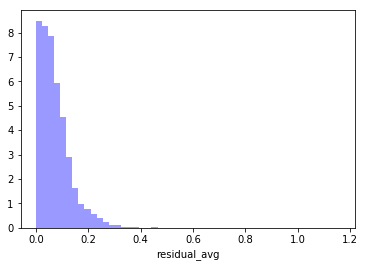

In [20]:
plt.figure()
sns.distplot(df_results_train['residual_avg'],norm_hist=True,kde=False,color='blue')


------------------ early time step of 1----------------------------


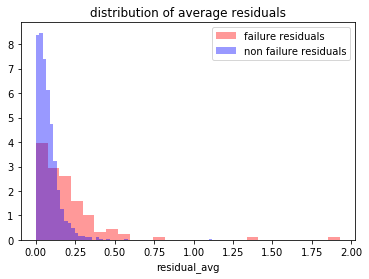

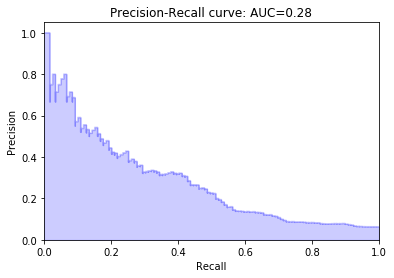

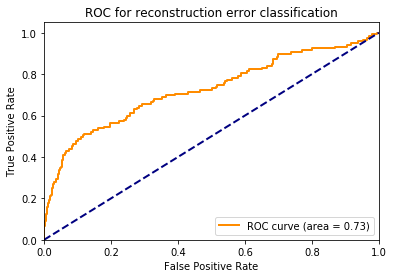



------ Using threshold 3s---------------
accuracy = 0.931
precision = 0.406
recall = 0.218
f1 = 0.284


------ Using threshold 5s---------------
accuracy = 0.938
precision = 0.550
recall = 0.092
f1 = 0.158


------ Using threshold max---------------
accuracy = 0.938
precision = 1.000
recall = 0.017
f1 = 0.033

------------------ early time step of 2----------------------------


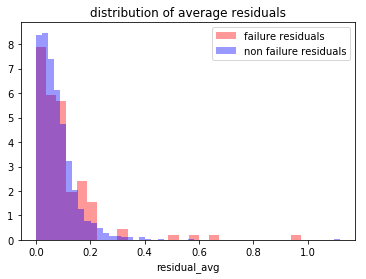

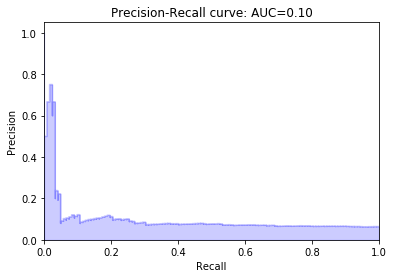

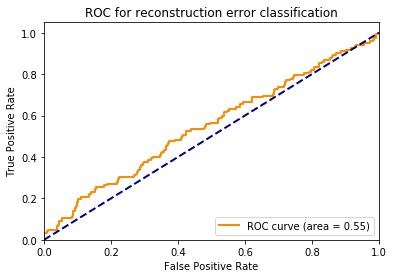



------ Using threshold 3s---------------
accuracy = 0.919
precision = 0.136
recall = 0.049
f1 = 0.072


------ Using threshold 5s---------------
accuracy = 0.933
precision = 0.308
recall = 0.033
f1 = 0.059


------ Using threshold max---------------
accuracy = 0.936
precision = 0.000
recall = 0.000
f1 = 0.000

------------------ early time step of 3----------------------------


/Users/chenpete/Documents/code/DL/dlenv/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/chenpete/Documents/code/DL/dlenv/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


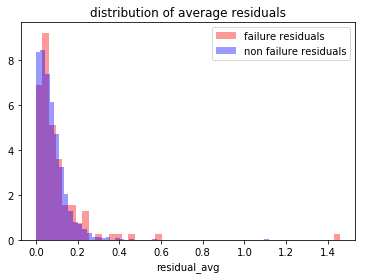

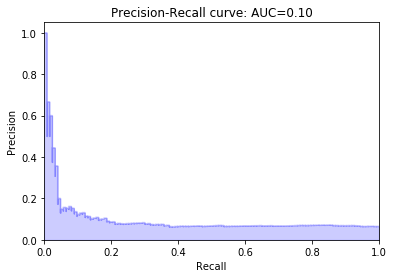

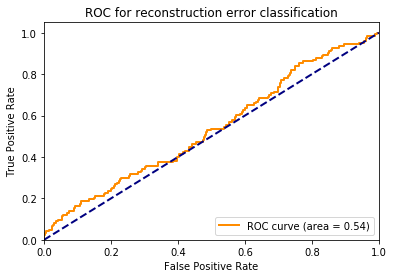



------ Using threshold 3s---------------
accuracy = 0.919
precision = 0.136
recall = 0.049
f1 = 0.072


------ Using threshold 5s---------------
accuracy = 0.933
precision = 0.308
recall = 0.033
f1 = 0.059


------ Using threshold max---------------
accuracy = 0.936
precision = 1.000
recall = 0.008
f1 = 0.016

------------------ early time step of 4----------------------------


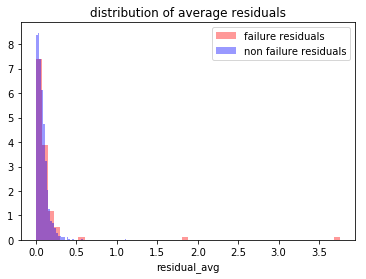

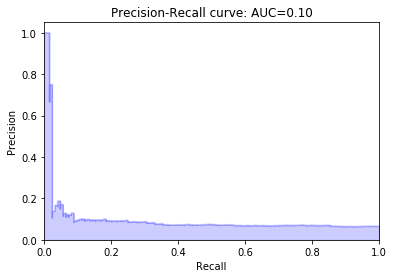

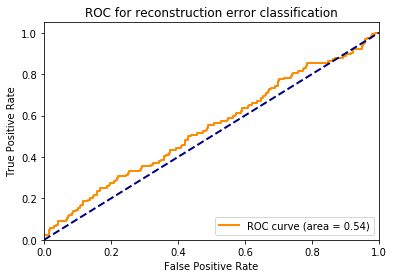



------ Using threshold 3s---------------
accuracy = 0.919
precision = 0.156
recall = 0.056
f1 = 0.083


------ Using threshold 5s---------------
accuracy = 0.932
precision = 0.250
recall = 0.024
f1 = 0.044


------ Using threshold max---------------
accuracy = 0.936
precision = 1.000
recall = 0.016
f1 = 0.032

------------------ early time step of 5----------------------------


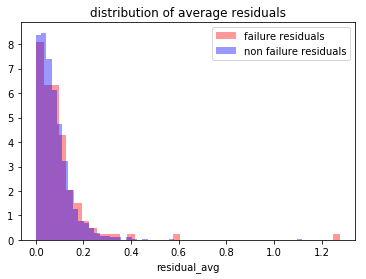

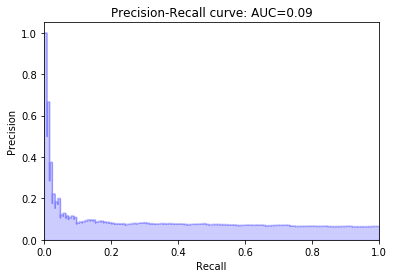

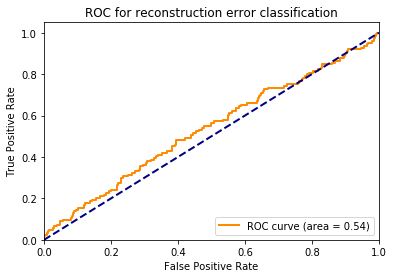



------ Using threshold 3s---------------
accuracy = 0.918
precision = 0.136
recall = 0.048
f1 = 0.071


------ Using threshold 5s---------------
accuracy = 0.932
precision = 0.250
recall = 0.024
f1 = 0.044


------ Using threshold max---------------
accuracy = 0.935
precision = 1.000
recall = 0.008
f1 = 0.016


In [21]:
for rank in range(1,np.max(df_results_test['y_rank'])+1):
    
    print('\n------------------ early time step of {}----------------------------'.format(rank))
    
    df_results_rank= df_results_test[(df_results_test['y_rank']==rank) | (df_results_test['y_rank']==0)]
    res_nominal_test = df_results_rank[df_results_rank['y'] == 0]['residual_avg']
    res_failures_test = df_results_rank[df_results_rank['y_rank'] == rank]['residual_avg']
    
    plt.figure()
    sns.distplot(res_failures_test,norm_hist=True,kde=False,color='red')
    sns.distplot(res_nominal_test,norm_hist=True,kde=False,color='blue')
    plt.legend(['failure residuals','non failure residuals'])
    plt.title('distribution of average residuals')

    y_true = np.array(df_results_rank['y'])
    y_pred_proba = np.array(df_results_rank['residual_avg']/np.max(df_results_rank['residual_avg']))
    plot_pr_curve(y_true,y_pred_proba)
    plot_roc(y_true,y_pred_proba)
    
    for name,threshold in threshold_list:
        print('\n\n------ Using threshold {}---------------'.format(name))
        y_pred_threshold = np.where(df_results_rank['residual_avg'] > threshold, 1, 0)
        
        print('accuracy = {:.3f}'.format(accuracy_score(y_true,y_pred_threshold)))
        print('precision = {:.3f}'.format(precision_score(y_true,y_pred_threshold)))
        print('recall = {:.3f}'.format(recall_score(y_true,y_pred_threshold)))
        print('f1 = {:.3f}'.format(f1_score(y_true,y_pred_threshold)))


(0, 0.75)

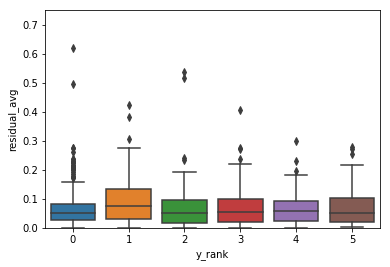

In [35]:
sns.boxplot(x='y_rank',y='residual_avg',data=df_results_test)
plt.ylim((0,.75))

# Try different ways to analyze reconstruction error

In [39]:
nominal_idx = y_rank_test==0
early1_idx = y_rank_test==1
early2_idx = y_rank_test==2
early3_idx = y_rank_test==3
early4_idx = y_rank_test==4


In [40]:
residuals_test = X_pred_test - X_test
residuals_train = X_pred_train - X_train

In [41]:
residuals_test = residuals_test[nominal_idx |early1_idx]
y_test_early1 = y_test[nominal_idx |early1_idx]

In [42]:
residuals_train.shape

(16896, 15)

In [43]:
residuals_test.shape

(1009, 15)

### Try std error for early interval = 1

In [44]:
residuals_train_mean = np.abs(np.mean(residuals_train,axis=1))
residuals_train_std = np.std(residuals_train,axis=1)

std_threshold = np.std(residuals_train_std) + 3*np.std(residuals_train_std)
std_threshold

0.7951178241585801

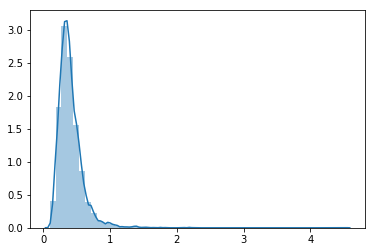

In [45]:
sns.distplot(residuals_train_std)

In [46]:
residuals_test_mean = np.abs(np.mean(residuals_test,axis=1))
residuals_test_std = np.std(residuals_test,axis=1)

In [47]:
residuals_test_std.shape

(1009,)

Text(0.5, 1.0, 'distribution of std residual')

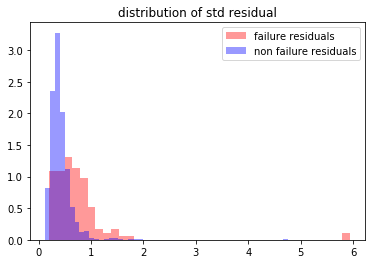

In [48]:
plt.figure()
sns.distplot(residuals_test_std[early1_idx],norm_hist=True,kde=False,color='red')
sns.distplot(residuals_test_std[nominal_idx],norm_hist=True,kde=False,color='blue')
plt.legend(['failure residuals','non failure residuals'])
plt.title('distribution of std residual')

In [49]:
y_pred_proba_std = residuals_test_std/np.max(residuals_test_std)

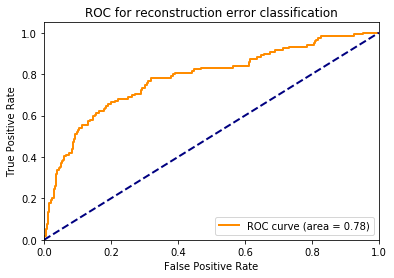

In [50]:
plot_roc(y_test_early1,y_pred_proba_std)

In [51]:
y_pred_threshold_std = np.where(residuals_test_std > std_threshold, 1, 0)

print('accuracy = {:.3f}'.format(accuracy_score(y_test_early1,y_pred_threshold_std)))
print('precision = {:.3f}'.format(precision_score(y_test_early1,y_pred_threshold_std)))
print('recall = {:.3f}'.format(recall_score(y_test_early1,y_pred_threshold_std)))
print('f1 = {:.3f}'.format(f1_score(y_test_early1,y_pred_threshold_std)))

accuracy = 0.887
precision = 0.535
recall = 0.319
f1 = 0.400


### Look at all errors

## KNN on reconstruction error

In [55]:
tree = BallTree(residuals_train)

In [56]:
dist,ind = tree.query(residuals_test,k=1)
dist = pd.Series(dist.ravel(),index=residuals_test.index)

Text(0.5, 1.0, 'distribution of std residual')

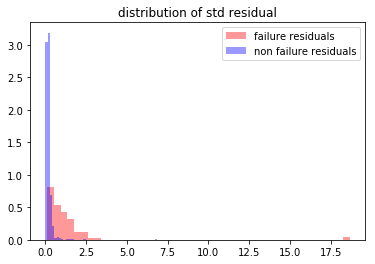

In [57]:
plt.figure()
sns.distplot(dist[early1_idx],norm_hist=True,kde=False,color='red')
sns.distplot(dist[nominal_idx],norm_hist=True,kde=False,color='blue')
plt.legend(['failure residuals','non failure residuals'])
plt.title('distribution of std residual')

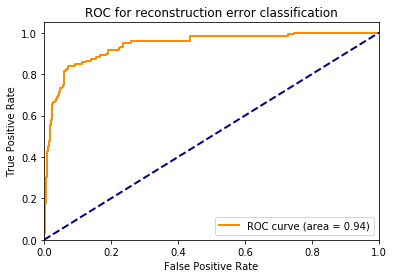

In [58]:
y_pred_proba_knn = dist/np.max(dist)
plot_roc(y_test_early1,y_pred_proba_knn)

In [59]:
y_pred_threshold_knn = np.where(dist > 1.5, 1, 0)
print('accuracy = {:.3f}'.format(accuracy_score(y_test_early1,y_pred_threshold_knn)))
print('precision = {:.3f}'.format(precision_score(y_test_early1,y_pred_threshold_knn)))
print('recall = {:.3f}'.format(recall_score(y_test_early1,y_pred_threshold_knn)))
print('f1 = {:.3f}\n\n'.format(f1_score(y_test_early1,y_pred_threshold_knn)))
print(confusion_matrix(y_test_early1,y_pred_threshold_knn))

accuracy = 0.904
precision = 0.844
recall = 0.227
f1 = 0.358


[[885   5]
 [ 92  27]]
